# 🧠 Brain Tumor Detection using Deep Learning

This notebook demonstrates a complete pipeline for detecting and classifying brain tumors from MRI scans using Convolutional Neural Networks (CNN).

## 📋 Project Overview

**Objective:** Classify brain MRI scans into 4 categories:
- **Glioma Tumor** - A type of tumor that occurs in the brain and spinal cord
- **Meningioma Tumor** - Tumor that arises from the meninges
- **Pituitary Tumor** - Abnormal growth in the pituitary gland
- **No Tumor** - Healthy brain scan

**Dataset:** [Brain Tumor MRI Dataset](https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset)

**Approach:**
1. Data Loading & Exploration
2. Data Preprocessing & Augmentation
3. Custom CNN Model Architecture
4. Model Training & Validation
5. Performance Evaluation
6. Visualization (Grad-CAM for interpretability)

## 📦 1. Import Required Libraries

In [1]:
# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data Analysis & Visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

# Model Evaluation
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Utilities
import os
import itertools
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Display versions
print(f"TensorFlow version: {tf.__version__}")
print(f"NumPy version: {np.__version__}")

# Configure matplotlib
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

TensorFlow version: 2.20.0
NumPy version: 2.2.4


## 📂 2. Dataset Setup & Exploration

The dataset is organized into Training and Testing folders, each containing 4 subfolders for each tumor type.

In [2]:
# Dataset paths
BASE_DIR = Path.cwd()
DATA_DIR = BASE_DIR / "brain_tumor_dataset"
TRAIN_DIR = DATA_DIR / "Training"
TEST_DIR = DATA_DIR / "Testing"

print("Dataset Structure:")
print(f"Base Directory: {BASE_DIR}")
print(f"Dataset Directory: {DATA_DIR}")
print(f"Training Directory: {TRAIN_DIR}")
print(f"Testing Directory: {TEST_DIR}")

# Verify directories exist
assert TRAIN_DIR.exists(), f"Training directory not found: {TRAIN_DIR}"
assert TEST_DIR.exists(), f"Testing directory not found: {TEST_DIR}"
print("\n✅ All directories found!")

Dataset Structure:
Base Directory: c:\Users\prem\OneDrive\Desktop\b
Dataset Directory: c:\Users\prem\OneDrive\Desktop\b\brain_tumor_dataset
Training Directory: c:\Users\prem\OneDrive\Desktop\b\brain_tumor_dataset\Training
Testing Directory: c:\Users\prem\OneDrive\Desktop\b\brain_tumor_dataset\Testing

✅ All directories found!


In [3]:
# Count samples per class
def count_samples(directory):
    """Count samples in each class"""
    data = []
    for class_dir in directory.iterdir():
        if class_dir.is_dir():
            count = len(list(class_dir.glob("*.*")))
            data.append({
                'Class': class_dir.name,
                'Count': count
            })
    return pd.DataFrame(data)

# Get counts
train_counts = count_samples(TRAIN_DIR)
test_counts = count_samples(TEST_DIR)

print("Training Set Distribution:")
print(train_counts.to_string(index=False))
print(f"\nTotal Training Samples: {train_counts['Count'].sum()}")

print("\nTesting Set Distribution:")
print(test_counts.to_string(index=False))
print(f"\nTotal Testing Samples: {test_counts['Count'].sum()}")

Training Set Distribution:
     Class  Count
    glioma   1321
meningioma   1339
   notumor   1595
 pituitary   1457

Total Training Samples: 5712

Testing Set Distribution:
     Class  Count
    glioma    300
meningioma    306
   notumor    405
 pituitary    300

Total Testing Samples: 1311


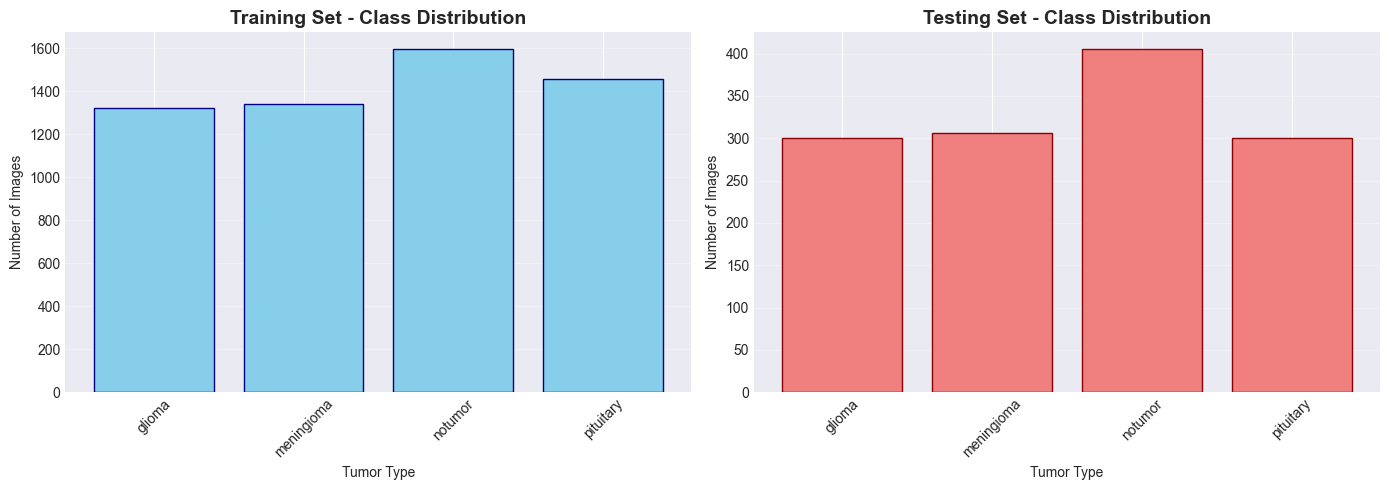

In [4]:
# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training distribution
axes[0].bar(train_counts['Class'], train_counts['Count'], color='skyblue', edgecolor='navy')
axes[0].set_title('Training Set - Class Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Tumor Type')
axes[0].set_ylabel('Number of Images')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)

# Testing distribution
axes[1].bar(test_counts['Class'], test_counts['Count'], color='lightcoral', edgecolor='darkred')
axes[1].set_title('Testing Set - Class Distribution', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Tumor Type')
axes[1].set_ylabel('Number of Images')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 🖼️ 3. Visualize Sample Images

Let's look at sample images from each class to understand what we're working with.

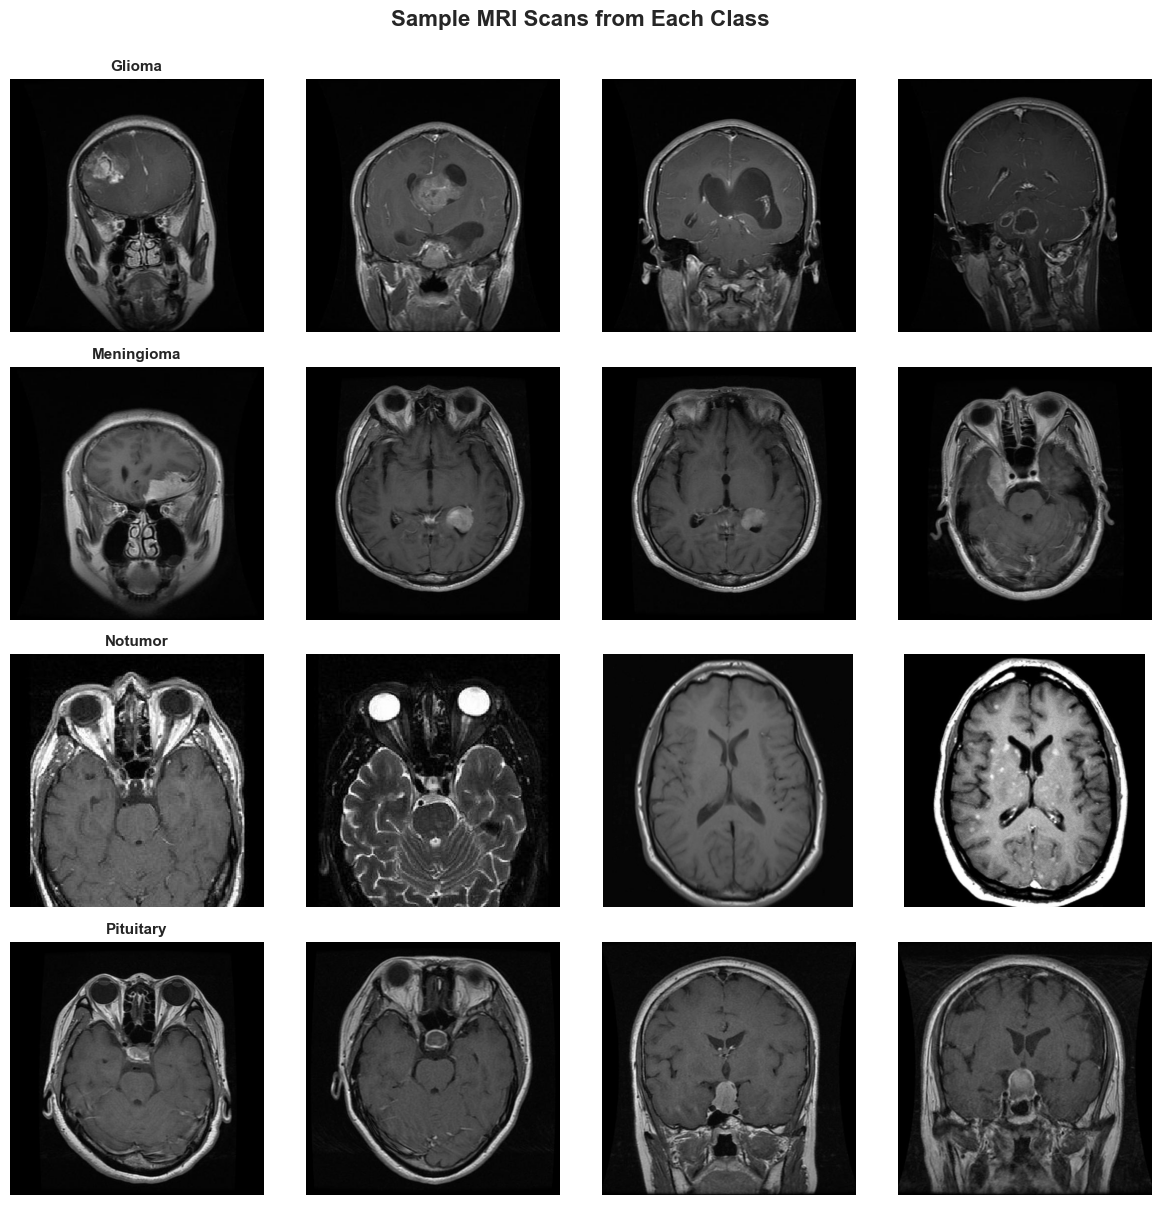

In [5]:
# Display sample images from each class
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
fig.suptitle('Sample MRI Scans from Each Class', fontsize=16, fontweight='bold', y=1.00)

class_names = [d.name for d in TRAIN_DIR.iterdir() if d.is_dir()]

for i, class_name in enumerate(sorted(class_names)):
    class_dir = TRAIN_DIR / class_name
    images = list(class_dir.glob("*.jpg"))[:4]  # Get first 4 images
    
    for j, img_path in enumerate(images):
        img = plt.imread(img_path)
        axes[i, j].imshow(img, cmap='gray')
        axes[i, j].axis('off')
        if j == 0:
            axes[i, j].set_title(class_name.replace('_', ' ').title(), 
                                fontweight='bold', fontsize=11)

plt.tight_layout()
plt.show()

## ⚙️ 4. Data Preprocessing & Augmentation

Data augmentation helps the model generalize better by creating variations of training images.

In [6]:
# Configuration
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
NUM_EPOCHS = 15

print("Training Configuration:")
print(f"Image Size: {IMG_SIZE}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Epochs: {NUM_EPOCHS}")

Training Configuration:
Image Size: (224, 224)
Batch Size: 16
Epochs: 15


In [7]:
# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,                # Normalize pixel values to [0,1]
    rotation_range=15,             # Random rotation ±15 degrees
    width_shift_range=0.1,         # Horizontal shift
    height_shift_range=0.1,        # Vertical shift
    shear_range=0.1,               # Shear transformation
    zoom_range=0.1,                # Random zoom
    horizontal_flip=True,          # Random horizontal flip
    fill_mode='nearest'            # Fill strategy for new pixels
)

# Only rescaling for test data (no augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)

print("✅ Data augmentation configured")

✅ Data augmentation configured


In [8]:
# Create data generators
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

CLASS_NAMES = list(train_generator.class_indices.keys())
NUM_CLASSES = len(CLASS_NAMES)

print(f"\n Classes: {CLASS_NAMES}")
print(f"Number of classes: {NUM_CLASSES}")

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.

 Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
Number of classes: 4


## 🏗️ 5. Build CNN Model Architecture

We'll create a custom CNN with:
- 4 convolutional blocks with batch normalization
- Dropout for regularization
- Global average pooling
- Dense layers for classification

In [9]:
# Build the CNN model
model = keras.Sequential([
    # Input layer
    layers.Input(shape=(*IMG_SIZE, 3)),
    
    # Block 1: 32 filters
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    
    # Block 2: 64 filters
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    
    # Block 3: 128 filters
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    
    # Block 4: 256 filters
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.GlobalAveragePooling2D(),
    
    # Dense layers
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    
    # Output layer
    layers.Dense(NUM_CLASSES, activation='softmax')
], name="BrainTumorCNN")

# Display model architecture
model.summary()

Model: "BrainTumorCNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,443,108 (5.51 MB)

 Trainable params: 1,439,652 (5.49 MB)

 Non-trainable params: 3,456 (13.50 KB)

## 🔧 6. Compile the Model

In [10]:
# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("✅ Model compiled successfully!")

✅ Model compiled successfully!


## 📈 7. Setup Callbacks

Callbacks help monitor and control the training process:
- **ModelCheckpoint**: Save the best model
- **ReduceLROnPlateau**: Reduce learning rate when validation loss plateaus
- **EarlyStopping**: Stop training if no improvement

In [11]:
# Define callbacks
checkpoint_path = "brain_tumor_model.h5"

callbacks = [
    keras.callbacks.ModelCheckpoint(
        checkpoint_path,
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    ),
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    )
]

print("✅ Callbacks configured")

✅ Callbacks configured


## 🚀 8. Train the Model

**Note:** Training will take approximately 10-15 minutes depending on your hardware (faster with GPU).

In [12]:
# Train the model
print("🚀 Starting training...\n")

history = model.fit(
    train_generator,
    epochs=NUM_EPOCHS,
    validation_data=test_generator,
    callbacks=callbacks,
    verbose=1
)

print("\n✅ Training completed!")

🚀 Starting training...

Epoch 1/15
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5430 - loss: 1.2846
Epoch 1: val_accuracy improved from None to 0.26697, saving model to brain_tumor_model.h5


357/357 ━━━━━━━━━━━━━━━━━━━━ 840s 2s/step - accuracy: 0.6085 - loss: 1.0964 - val_accuracy: 0.2670 - val_loss: 2.0232 - learning_rate: 1.0000e-04
Epoch 2/15
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6994 - loss: 0.8870
Epoch 2: val_accuracy improved from 0.26697 to 0.32952, saving model to brain_tumor_model.h5


357/357 ━━━━━━━━━━━━━━━━━━━━ 712s 2s/step - accuracy: 0.7066 - loss: 0.8419 - val_accuracy: 0.3295 - val_loss: 4.2735 - learning_rate: 1.0000e-04
Epoch 3/15
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7304 - loss: 0.7489
Epoch 3: val_accuracy improved from 0.32952 to 0.41648, saving model to brain_tumor_model.h5


357/357 ━━━━━━━━━━━━━━━━━━━━ 723s 2s/step - accuracy: 0.7426 - loss: 0.7176 - val_accuracy: 0.4165 - val_loss: 4.1329 - learning_rate: 1.0000e-04
Epoch 4/15
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7724 - loss: 0.6650
Epoch 4: val_accuracy improved from 0.41648 to 0.44928, saving model to brain_tumor_model.h5



Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
357/357 ━━━━━━━━━━━━━━━━━━━━ 758s 2s/step - accuracy: 0.7757 - loss: 0.6345 - val_accuracy: 0.4493 - val_loss: 3.5656 - learning_rate: 1.0000e-04
Epoch 5/15
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8035 - loss: 0.5776
Epoch 5: val_accuracy improved from 0.44928 to 0.50801, saving model to brain_tumor_model.h5


357/357 ━━━━━━━━━━━━━━━━━━━━ 760s 2s/step - accuracy: 0.8081 - loss: 0.5523 - val_accuracy: 0.5080 - val_loss: 4.1552 - learning_rate: 5.0000e-05
Epoch 6/15
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8242 - loss: 0.4797
Epoch 6: val_accuracy did not improve from 0.50801
357/357 ━━━━━━━━━━━━━━━━━━━━ 750s 2s/step - accuracy: 0.8242 - loss: 0.4952 - val_accuracy: 0.5057 - val_loss: 3.6562 - learning_rate: 5.0000e-05
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.

✅ Training completed!


## 📊 9. Visualize Training History

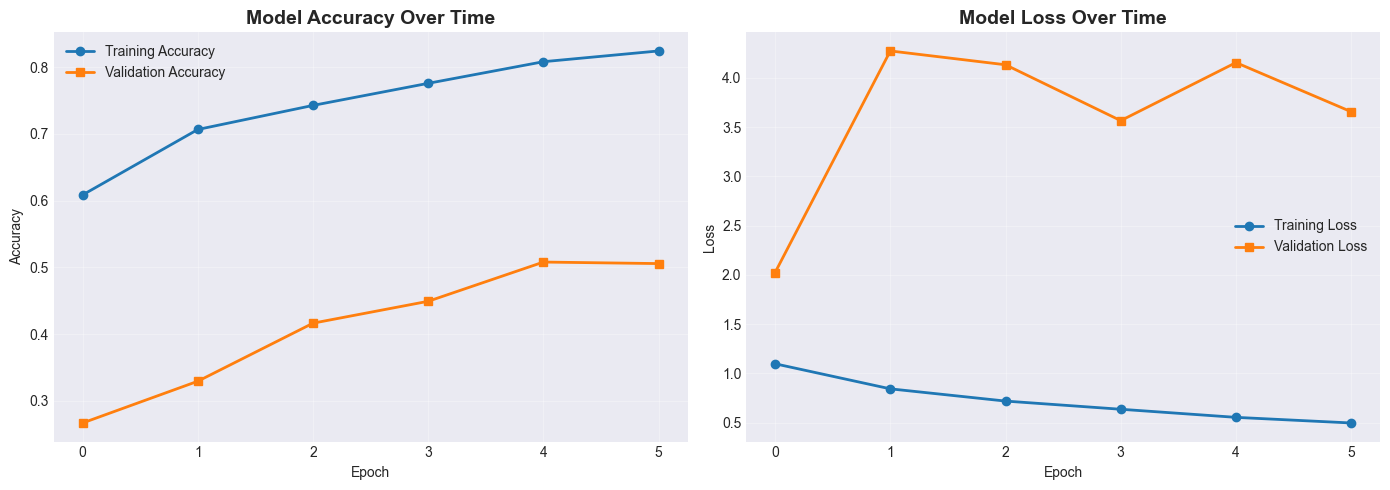

📊 Training plots saved as 'training_history.png'


In [13]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy plot
axes[0].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2, marker='o')
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2, marker='s')
axes[0].set_title('Model Accuracy Over Time', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Loss plot
axes[1].plot(history.history['loss'], label='Training Loss', linewidth=2, marker='o')
axes[1].plot(history.history['val_loss'], label='Validation Loss', linewidth=2, marker='s')
axes[1].set_title('Model Loss Over Time', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print("📊 Training plots saved as 'training_history.png'")

## 🎯 10. Model Evaluation

Let's evaluate the model's performance on the test set.

In [14]:
# Make predictions
print("Making predictions on test set...")
y_pred_probs = model.predict(test_generator, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"\n🎯 Test Accuracy: {accuracy * 100:.2f}%")

Making predictions on test set...
82/82 ━━━━━━━━━━━━━━━━━━━━ 27s 317ms/step

🎯 Test Accuracy: 26.70%


In [15]:
# Classification report
print("\n" + "="*60)
print("CLASSIFICATION REPORT")
print("="*60)
print(classification_report(y_true, y_pred, target_names=CLASS_NAMES, digits=4))


CLASSIFICATION REPORT
              precision    recall  f1-score   support

      glioma     1.0000    0.0400    0.0769       300
  meningioma     0.0000    0.0000    0.0000       306
     notumor     0.3167    0.0938    0.1448       405
   pituitary     0.2545    1.0000    0.4057       300

    accuracy                         0.2670      1311
   macro avg     0.3928    0.2835    0.1568      1311
weighted avg     0.3849    0.2670    0.1552      1311



## 📉 11. Confusion Matrix

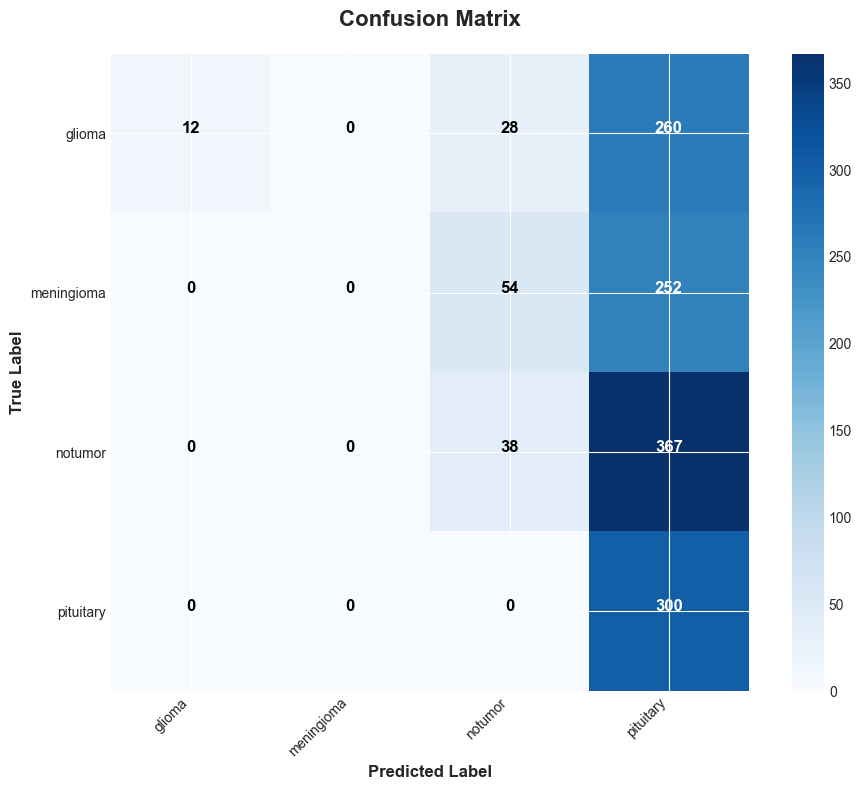

📊 Confusion matrix saved as 'confusion_matrix.png'


In [16]:
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontsize=16, fontweight='bold', pad=20)
plt.colorbar()

tick_marks = np.arange(len(CLASS_NAMES))
plt.xticks(tick_marks, CLASS_NAMES, rotation=45, ha='right')
plt.yticks(tick_marks, CLASS_NAMES)

# Add text annotations
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black",
             fontsize=12, fontweight='bold')

plt.ylabel('True Label', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("📊 Confusion matrix saved as 'confusion_matrix.png'")

## 💾 12. Save the Final Model

In [17]:
# Save the model
final_model_path = "brain_tumor_model_final.h5"
model.save(final_model_path)
print(f"✅ Model saved as '{final_model_path}'")
print(f"\nModel size: {os.path.getsize(final_model_path) / (1024**2):.2f} MB")

✅ Model saved as 'brain_tumor_model_final.h5'

Model size: 16.66 MB


## 🔥 13. Grad-CAM Visualization (Optional)

Grad-CAM (Gradient-weighted Class Activation Mapping) helps visualize which parts of the image the model focuses on for making predictions.

In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name=None, pred_index=None):
    """Generate Grad-CAM heatmap for a given model and convolutional layer.
    Returns: (heatmap_numpy, used_last_conv_layer_name)
    """
    # Ensure the model is built/called so layers have inbound nodes (outputs).
    if not getattr(model, 'inputs', None) or not getattr(model, 'outputs', None):
        # Build model by running a single forward pass with a dummy input matching the shape
        dummy = tf.zeros((1, IMG_SIZE[0], IMG_SIZE[1], 3), dtype=tf.float32)
        _ = model.predict(dummy)
    
    # Auto-detect the last conv layer if name not provided
    if last_conv_layer_name is None:
        # prefer a real Conv2D instance, fall back to name containing 'conv', then search nested layers
        last_conv_layer_name = None
        for layer in reversed(model.layers):
            if isinstance(layer, tf.keras.layers.Conv2D):
                last_conv_layer_name = layer.name
                break
        if last_conv_layer_name is None:
            for layer in reversed(model.layers):
                if 'conv' in layer.name.lower():
                    last_conv_layer_name = layer.name
                    break
        # look inside nested submodels if still not found
        if last_conv_layer_name is None:
            for layer in model.layers:
                if hasattr(layer, 'layers'):
                    for sub in reversed(layer.layers):
                        if isinstance(sub, tf.keras.layers.Conv2D):
                            last_conv_layer_name = sub.name
                            break
                    if last_conv_layer_name:
                        break
        if last_conv_layer_name is None:
            raise ValueError('Could not find a convolutional layer in the model for Grad-CAM')
    
    # Get the convolutional layer and create a grad model that outputs conv maps + predictions
    conv_layer = model.get_layer(last_conv_layer_name)
    grad_model = tf.keras.models.Model([model.inputs], [conv_layer.output, model.output])
    
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]
    
    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    conv_outputs = conv_outputs[0]
    # Weighted combination of activations and pooled gradients
    heatmap = tf.reduce_sum(tf.multiply(conv_outputs, pooled_grads), axis=-1)
    heatmap = tf.maximum(heatmap, 0) / (tf.reduce_max(heatmap) + 1e-8)
    
    return heatmap.numpy(), last_conv_layer_name

# Try to detect a last conv layer name now (best-effort)
try:
    # This will build the model and return a dummy heatmap and the detected layer name
    _, detected_last_conv = make_gradcam_heatmap(tf.zeros((1, IMG_SIZE[0], IMG_SIZE[1], 3)), model)
    last_conv_layer_name = detected_last_conv
except Exception as e:
    # Fallback detection without gradients
    last_conv_layer_name = None
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            last_conv_layer_name = layer.name
            break
    if last_conv_layer_name is None:
        for layer in reversed(model.layers):
            if 'conv' in layer.name.lower():
                last_conv_layer_name = layer.name
                break
    if last_conv_layer_name is None:
        print('Warning: could not auto-detect a conv layer for Grad-CAM; you may need to set last_conv_layer_name manually')
    else:
        print(f"Using layer '{last_conv_layer_name}' for Grad-CAM")

Using layer 'conv2d_7' for Grad-CAM


AttributeError: The layer BrainTumorCNN has never been called and thus has no defined output.

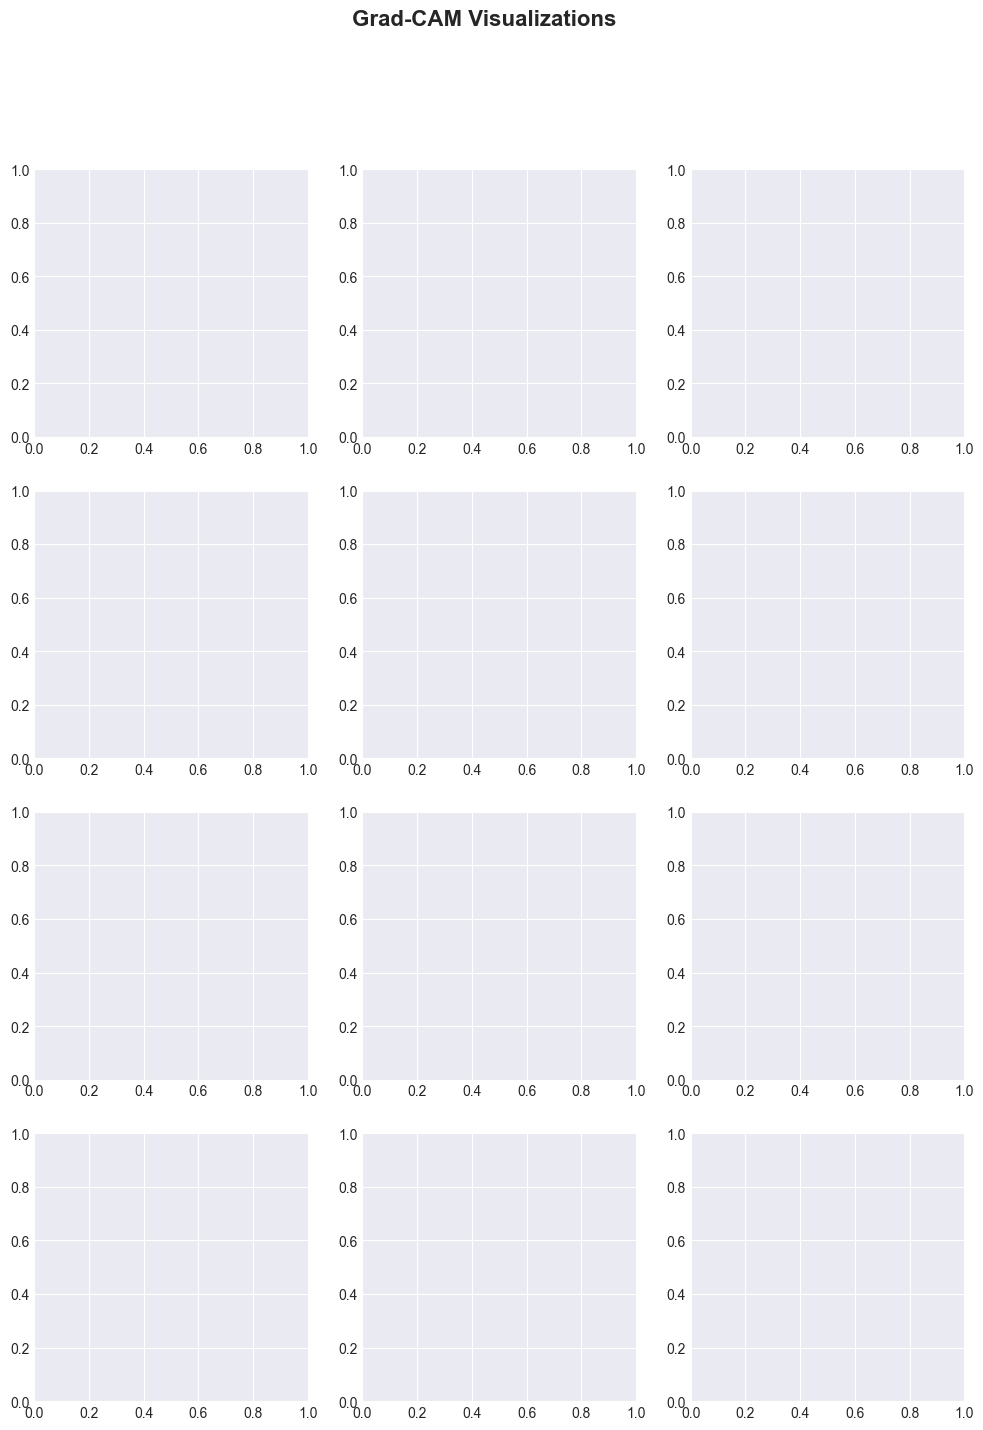

In [ ]:
# Display Grad-CAM for sample images
fig, axes = plt.subplots(4, 3, figsize=(12, 16))
fig.suptitle('Grad-CAM Visualizations', fontsize=16, fontweight='bold')

# Get a batch of test images
test_generator.reset()
x_batch, y_batch = next(test_generator)

for i in range(4):
    img = x_batch[i]
    # Ensure image is uint8 RGB for plotting and overlay
    if img.dtype == np.float32 or img.dtype == np.float64:
        img_uint8 = np.clip(img * 255.0, 0, 255).astype(np.uint8)
    else:
        img_uint8 = img.copy().astype(np.uint8)

    img_array = np.expand_dims(img, axis=0)
    
    # Make prediction
    preds = model.predict(img_array, verbose=0)
    pred_class = int(np.argmax(preds[0]))
    true_class = int(np.argmax(y_batch[i]))
    
    # Generate heatmap (unpack heatmap and possibly detected layer)
    try:
        heatmap, last_conv_layer_name = make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_class)
    except AttributeError:
        # Ensure model is called/built and retry (fixes "layer has never been called" issue)
        _ = model.predict(img_array, verbose=0)
        heatmap, last_conv_layer_name = make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_class)

    # Fallback to a blank heatmap if something unexpected happens
    if heatmap is None:
        heatmap = np.zeros((IMG_SIZE[0], IMG_SIZE[1]), dtype=np.float32)
    # Resize & convert heatmap to uint8
    heatmap_resized = cv2.resize(heatmap, (IMG_SIZE[1], IMG_SIZE[0]))
    heatmap_uint8 = np.uint8(255 * np.clip(heatmap_resized, 0, 1))
    # Apply color map (returns BGR), convert to RGB for matplotlib
    heatmap_color = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_JET)
    heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB)

    # Superimpose heatmap on image using cv2.addWeighted
    superimposed = cv2.addWeighted(img_uint8, 0.6, heatmap_color, 0.4, 0)
    
    # Display
    axes[i, 0].imshow(img_uint8)
    axes[i, 0].set_title(f"True: {CLASS_NAMES[true_class]}")
    axes[i, 0].axis('off')
    
    axes[i, 1].imshow(heatmap_uint8, cmap='jet')
    axes[i, 1].set_title("Heatmap")
    axes[i, 1].axis('off')
    
    axes[i, 2].imshow(superimposed)
    axes[i, 2].set_title(f"Pred: {CLASS_NAMES[pred_class]} ({preds[0][pred_class]*100:.1f}%)")
    axes[i, 2].axis('off')

plt.tight_layout()
plt.savefig('gradcam_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

print("🔥 Grad-CAM visualizations saved as 'gradcam_visualization.png'")

## 📝 14. Summary

### What We Accomplished:

1. ✅ **Loaded and explored** the Brain Tumor MRI dataset
2. ✅ **Preprocessed images** with data augmentation
3. ✅ **Built a custom CNN** with 4 convolutional blocks
4. ✅ **Trained the model** with callbacks for optimization
5. ✅ **Evaluated performance** with accuracy metrics
6. ✅ **Visualized results** with confusion matrix and Grad-CAM
7. ✅ **Saved the model** for deployment

### Next Steps:

- Deploy the model using the Flask web application (`app.py`)
- Test with new MRI scans
- Further improve accuracy with hyperparameter tuning
- Experiment with transfer learning (ResNet, EfficientNet, etc.)

### 🌐 Web Application:

Run the web app to test predictions:
```bash
python app.py
```
Then open: http://localhost:5000